In [2]:
# 96% accuracy on LFW database
#
#

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np

from matplotlib import pyplot as plt

In [3]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


(10585, 100, 100, 3)
(10585,)
2381
8204
0.2249
(2648, 100, 100, 3)
(2648,)
596
2052
0.2251


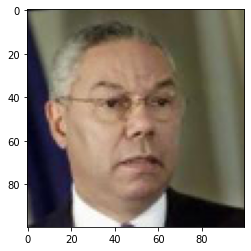

(10585, 100, 100, 3)
(2648, 100, 100, 3)


In [4]:
# Load 
x_train = np.load('gender/x_train.npy')
x_test = np.load('gender/x_test.npy')

y_train = np.load('gender/y_train.npy')
y_test = np.load('gender/y_test.npy')

# Stats
print(x_train.shape)
print(y_train.shape)
print(sum(y_train == 1))
print(sum(y_train == 0))
print("{:.4f}".format(sum(y_train == 1)/y_train.shape[0]))
print(x_test.shape)
print(y_test.shape)
print(sum(y_test == 1))
print(sum(y_test == 0))
print("{:.4f}".format(sum(y_test == 1)/y_test.shape[0]))


## View some images
plt.imshow(x_train[0,:,:,: ] )
plt.show()


## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [5]:
batch_size = 128
epochs = 75

In [5]:
## DEFINE A DATA AUGMENTATION GENERATOR

datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)


## DEF A BLOCK CONV + BN + GN + MAXPOOL
def CBGN(model,filters,ishape=0):
  if (ishape!=0):
    model.add(Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape))
    model.add(Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape))
  else:
    model.add(Conv2D(filters, (3, 3), padding='same'))
    model.add(Conv2D(filters, (3, 3), padding='same'))
  
  model.add(BN())
  model.add(GN(0.3))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  
  return model

  
## DEF NN TOPOLOGY  
model = Sequential()

model=CBGN(model,32,x_train.shape[1:])
model=CBGN(model,32)
model=CBGN(model,64)
model=CBGN(model,64)

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))


model.summary()


## OPTIM AND COMPILE
opt = SGD(lr=0.1, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# DEFINE A LEARNING RATE SCHEDULER
def scheduler(epoch):
    if epoch < 25:
        return .1
    elif epoch < 50:
        return 0.01
    else:
        return 0.001

set_lr = LRS(scheduler)


## TRAINING with DA and LRA
history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[set_lr],
                            verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 100, 100, 32)      0         
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 32)       

83/82 [==============================] - 1111s 13s/step - loss: 0.1590 - accuracy: 0.9363 - val_loss: 0.1199 - val_accuracy: 0.9517
Epoch 30/75
83/82 [==============================] - 1158s 14s/step - loss: 0.1541 - accuracy: 0.9390 - val_loss: 0.1062 - val_accuracy: 0.9569
Epoch 31/75
83/82 [==============================] - 1175s 14s/step - loss: 0.1548 - accuracy: 0.9393 - val_loss: 0.1154 - val_accuracy: 0.9532
Epoch 32/75
83/82 [==============================] - 1106s 13s/step - loss: 0.1531 - accuracy: 0.9379 - val_loss: 0.1278 - val_accuracy: 0.9505
Epoch 33/75
83/82 [==============================] - 966s 12s/step - loss: 0.1428 - accuracy: 0.9408 - val_loss: 0.1121 - val_accuracy: 0.9577
Epoch 34/75
83/82 [==============================] - 957s 12s/step - loss: 0.1485 - accuracy: 0.9400 - val_loss: 0.1055 - val_accuracy: 0.9573
Epoch 35/75
83/82 [==============================] - 977s 12s/step - loss: 0.1455 - accuracy: 0.9410 - val_loss: 0.1055 - val_accuracy: 0.9592
Epoch 3

In [13]:
x_test.shape[1:]

(100, 100, 3)

In [6]:
print(x_train.shape)
print(x_test.shape)

(10585, 100, 100, 3)
(2648, 100, 100, 3)


In [7]:
print(y_train.shape)
print(y_test.shape)

(10585, 2)
(2648, 2)
